# Project 5 : Ocean Warming

# Access to data in the cloud (GCS)

## Import modules and libraries

*First, let's make sure the Python env is correct to run this notebook*:

In [1]:
import os, sys, urllib, tempfile
with tempfile.TemporaryDirectory() as tmpdirname:
    sys.path.append(tmpdirname)
    repo = "https://raw.githubusercontent.com/obidam/ds2-2023/main/"
    urllib.request.urlretrieve(os.path.join(repo, "utils.py"),
                               os.path.join(tmpdirname, "utils.py"))
    from utils import check_up_env
    check_up_env()

/tmp/tmphm8ukut5/utils.py:39: UserWarning: 
Running on Google Colab, this set-up can take a few minutes
Be aware that your changes won't be saved unless you save this Notebooks on your G-Drive
  warnings.warn(


*Then, import the usual suspects*:

In [2]:
import xarray as xr
from intake import open_catalog

## Use intake catalog of data

The catalog also uses the gcsfs entry point, but with intake it's transparent to the user:

### Access and listing of the catalog

In [3]:
catalog_url = 'https://raw.githubusercontent.com/obidam/ds2-2023/main/ds2_data_catalog.yml'
cat = open_catalog(catalog_url)
list(cat)

['argo_global_sdl',
 'argo_global_sdl_homogeneous',
 'argo_global_vertical_mean',
 'en4',
 'sea_surface_height']

### Connect to data

In [4]:
ds = cat["en4"].to_dask()
print("Size of the dataset:", ds.nbytes/1e9,"Gb")
ds

Size of the dataset: 52.2317975 Gb


<xarray.Dataset>
Dimensions:                          (depth: 42, time: 832, bnds: 2, lat: 173,
                                      lon: 360)
Coordinates:
  * depth                            (depth) float32 5.022 15.08 ... 5.35e+03
  * lat                              (lat) float32 -83.0 -82.0 ... 88.0 89.0
  * lon                              (lon) float32 1.0 2.0 3.0 ... 359.0 360.0
  * time                             (time) datetime64[ns] 1950-01-16T12:00:0...
Dimensions without coordinates: bnds
Data variables:
    depth_bnds                       (time, depth, bnds) float32 dask.array<chunksize=(1, 42, 2), meta=np.ndarray>
    salinity                         (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    salinity_observation_weights     (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    salinity_uncertainty             (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    temperature                      (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    temperature_observation_weights  (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    temperature_uncertainty          (time, depth, lat, lon) float32 dask.array<chunksize=(1, 42, 173, 360), meta=np.ndarray>
    time_bnds                        (time, bnds) datetime64[ns] dask.array<chunksize=(832, 2), meta=np.ndarray>
Attributes: (12/21)
    Conventions:            CF-1.0
    DSD_entry_id:           UKMO-L4UHFnd-GLOB-v01
    GDS_version_id:         v1.7
    contact:                Simon Good - simon.good@metoffice.gov.uk
    creation_date:          2017-04-21 21:12:08.123 -00:00
    easternmost_longitude:  362.5
    ...                     ...
    start_date:             2001-01-01 UTC
    start_time:             00:00:00 UTC
    stop_date:              2001-01-01 UTC
    stop_time:              00:00:00 UTC
    title:                  Temperature and salinity analysis
    westernmost_longitude:  0.5

# Ocean Heat Content (OHC)

## Intro

In [5]:
import numpy as np

Firstly, we consider the density $\rho$ and heat capcity $C_p$ as constant.
* $\rho$ = 1035 $kg/m^{3}$
* $C_{\rho}$ =  4,186 J/(kg ⋅ K)

In [6]:
rho = 1035 # kg/m3
Cp = 4186 # J/K/kg

Then we can get the $OHC(x, y, z, t) [J]$ with
$$OHC(x,y,z,t) = \rho \cdot C_p \cdot V(x,y,z) \cdot T(x,y,z,t)$$
because the temperature $T$ can be obtained directly in the database, the main problem is to calculate the volume $V$ for the given latitude, longitude and depth.

## Calculation for V

We divide the ocean into cubes, each cube can be indicated by the longitude, latitude and deapth. The volume of cubes can be calculated with:
$$dV(x,y,z) = dA(x,y) \cdot dH(z)$$
$dA(x,y)$ presents the sub-area for cubes indicated by the given latitude and longitude. $dH(z)$ is the height of cubes, it may change according to the depth.

By considering the earth as a regular ball, we can get $dA(x,y)$ with:
$$dA(x,y) = R^2 ⋅ dϕ ⋅ dλ ⋅ cos(lat[rad])$$
R is the radius of the earth, $dϕ$ and $dλ$ can be obtained by `np.deg2rad(1.)`, $lat[rad]$ means the latitude in rad.

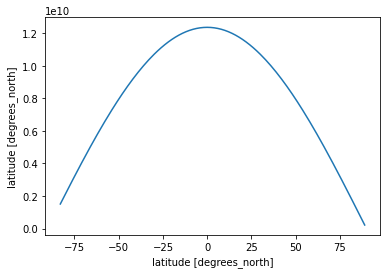

In [7]:
R = 6.37e6
# we know already that the spacing of the points is one degree latitude
dϕ = np.deg2rad(1.)
dλ = np.deg2rad(1.)
dA = R**2 * dϕ * dλ * np.cos(np.deg2rad(ds.lat))
dA.plot()

We add the result of $dA(x,y)$ into the dataset.

In [8]:
ds['dA'] = xr.DataArray(dA, dims=("lat"))

Then we need to calculate the height with given depth. By considering the given depth as the center of cubes, we can divide the cubes in the middle of 2 given depths. For the first and the last cube, we start from the surface of the ocean and end at the last depth we have.

In [9]:
depths = ds['depth']
depths = np.array((depths))
dz_0 = np.array(depths[0] + (depths[1]-depths[0])/2)
dz_i = (depths[1:-1]-depths[:-2])/2+(depths[2:]-depths[1:-1])/2
dz_N = np.array((depths[-1]-depths[-2])/2)

dz_0 = dz_0.reshape((1,1))
dz_N = dz_N.reshape((1,1))
dz_i = dz_i.reshape((-1,1))

dz = np.concatenate((dz_0, dz_i, dz_N))
dz = dz.reshape((-1))

We add the result of $dH(z)$ into the dataset.

In [10]:
ds['dz'] = xr.DataArray(dz, dims=("depth"))

## Calculation for OHC

Then wee can get the $OHC(x, y, z, t) [J]$ with
$$OHC(x,y,z,t) = \rho \cdot C_p \cdot A(x,y) \cdot H(z) \cdot T(x,y,z,t)$$

In [11]:
ds['OHC'] = rho * Cp * ds['temperature'] * ds['dz'] * ds['dA'] 

And then, we are going to see the result in 2 situations:
1. Depth < 2000
2. Depth < 700

In [12]:
depth2000 = ds.sel(depth=slice(None,2000))
depth700 = ds.sel(depth=slice(None,700))

For each situation, we calculate the OHC for the whole ocean.

In [13]:
depth2000['S_z_OHC'] = depth2000['OHC'].sum('depth')
depth2000['sum_S_z_OHC'] = depth2000['S_z_OHC'].sum(('lon','lat'))
depth2000['OHC_par_z'] = depth2000['OHC']/ds['dz']

In [14]:
depth700['S_z_OHC'] = depth700['OHC'].sum('depth')
depth700['sum_S_z_OHC'] = depth700['S_z_OHC'].sum(('lon','lat'))
depth700['OHC_par_z'] = depth700['OHC']/ds['dz']

## Result present

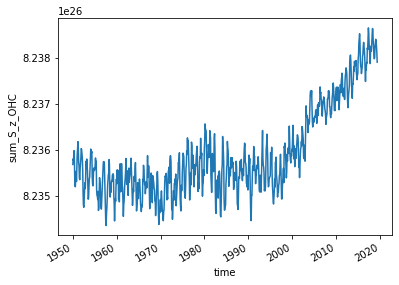

In [ ]:
depth2000['sum_S_z_OHC'].plot()

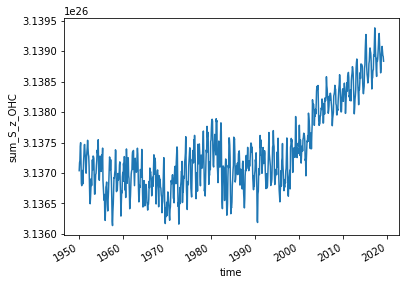

In [ ]:
depth700['sum_S_z_OHC'].plot()

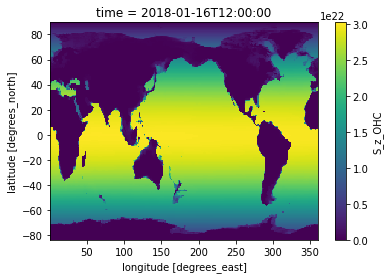

In [ ]:
depth2000['S_z_OHC'].sel(time='2018', method='nearest').plot()

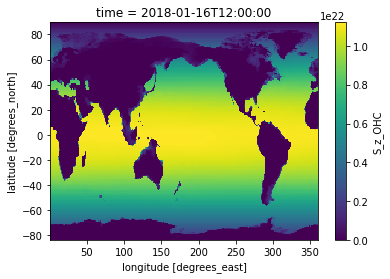

In [ ]:
depth700['S_z_OHC'].sel(time='2018', method='nearest').plot()

## Rescaling the data
To have more readable data and less important calculations, we decide to rescale the data to only consider the anomaly of OHC (compared to a reference, that is defined as `ref_OHC` below) in ZJ (and not J).

In [15]:
Y = depth700['sum_S_z_OHC']/1e21
ref_OHC = depth700['sum_S_z_OHC'].sel(time=slice("1950", "1954-12"))
ref_OHC = (ref_OHC/1e21).mean()
rescaled_Y = Y-ref_OHC
OHC_700 = np.array(rescaled_Y).reshape((-1,1))

In [16]:
Y = depth2000['sum_S_z_OHC']/1e21
ref_OHC = depth2000['sum_S_z_OHC'].sel(time=slice("1950", "1954-12"))
ref_OHC = (ref_OHC/1e21).mean()
rescaled_Y = Y-ref_OHC
OHC_2000 = np.array(rescaled_Y).reshape((-1,1))

# Regression

## Prepare the data

In [23]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [24]:
def regressor_predict(regressor, X_train, y_train, X_pred, X_plt_train, X_plt_pred, title="Predict", xlab='Time [years]', ylab=''):
  regressor.fit(X_train, y_train)
  y_pred = regressor.predict(X_pred)
  y_model = regressor.predict(X_train)
  
  plt.figure(figsize=(15,5))
  plt.title(title)
  plt.plot(X_plt_train / 12 + 1950,y_train,c='r',label='Observations')
  plt.plot(X_plt_pred / 12 + 1950,y_pred,c='k',label='Model + Prediction')
  plt.xlabel(xlab)
  plt.ylabel(ylab)
  plt.legend()
  # we divide the time by 12 (because 12 months in one year, and the time 
  # coordinate is in months) and we add 1950 (because the first time coordinate
  # is january 1950)

  RMSE = np.sqrt(mean_squared_error(y_train,y_model))
  return RMSE

In [25]:
X_aff = depth700.time
X_2019 = np.arange(0,len(depth700.time),1).reshape((-1,1))
X_2100 = np.arange(0,1824,1).reshape((-1,1)) 
# because december 2100 is the 1824th month (if january 1950 is the first)

Y_700 = OHC_700
Y_2000 = OHC_2000

In [26]:
# X composed with sin and cos
f=1/12 # because 12 month in one year, and one data every month

col1 = X_2019
col2 = np.sin(2*np.pi*f*col1)
col3 = np.sin(2*np.pi*f*col1)
X_sc_2019 = np.hstack((col1,col2,col3))

col1 = X_2100
col2 = np.sin(2*np.pi*f*col1)
col3 = np.sin(2*np.pi*f*col1)
X_sc_2100 = np.hstack((col1,col2,col3))

## Simple Linear Regression

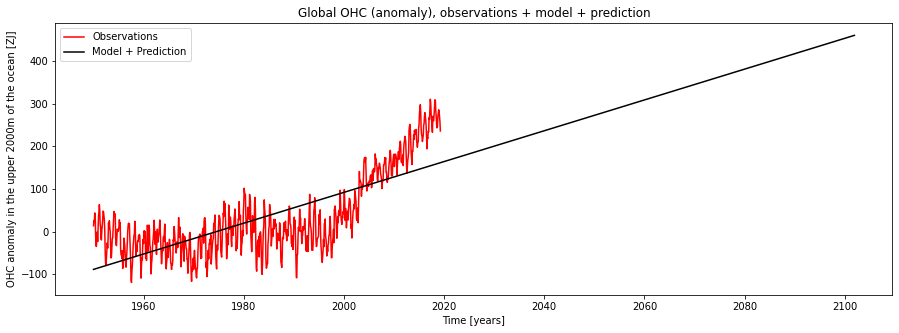

In [27]:
lr1 = LinearRegression()
RMSE_lin_2000 = regressor_predict(lr1, X_2019, Y_2000, X_2100, X_2019, X_2100, "Global OHC (anomaly), observations + model + prediction", 
                  "Time [years]", "OHC anomaly in the upper 2000m of the ocean [ZJ]")

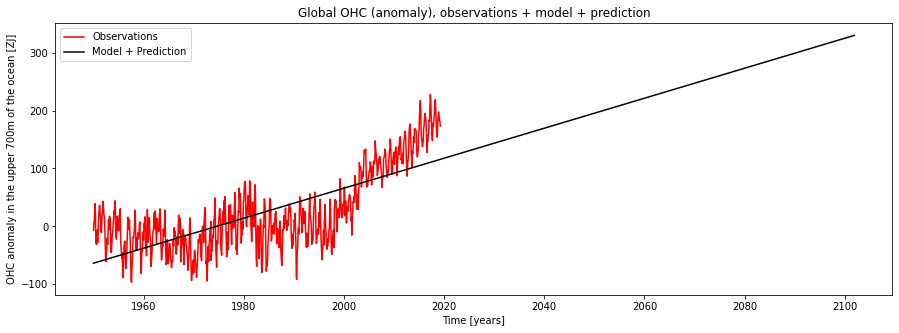

In [28]:
lr1 = LinearRegression()
RMSE_lin_700 = regressor_predict(lr1, X_2019, Y_700, X_2100, X_2019, X_2100, "Global OHC (anomaly), observations + model + prediction", 
                  "Time [years]", "OHC anomaly in the upper 700m of the ocean [ZJ]")

## Linear Regression with sin and cos

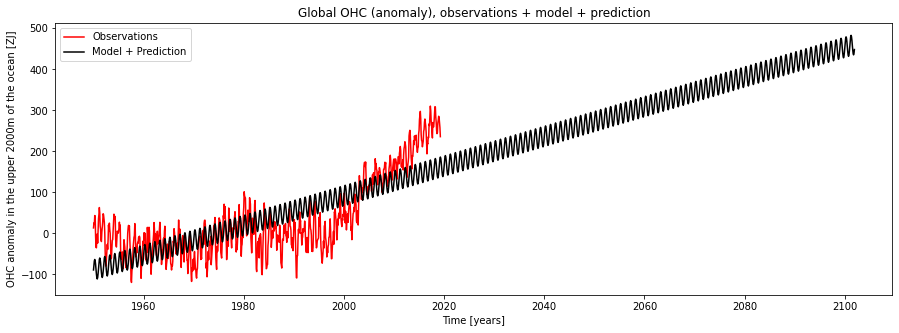

In [29]:
lr2 = LinearRegression()
RMSE_sin_2000 = regressor_predict(lr2, X_sc_2019, Y_2000, X_sc_2100, X_2019, X_2100, "Global OHC (anomaly), observations + model + prediction", 
                  "Time [years]", "OHC anomaly in the upper 2000m of the ocean [ZJ]")

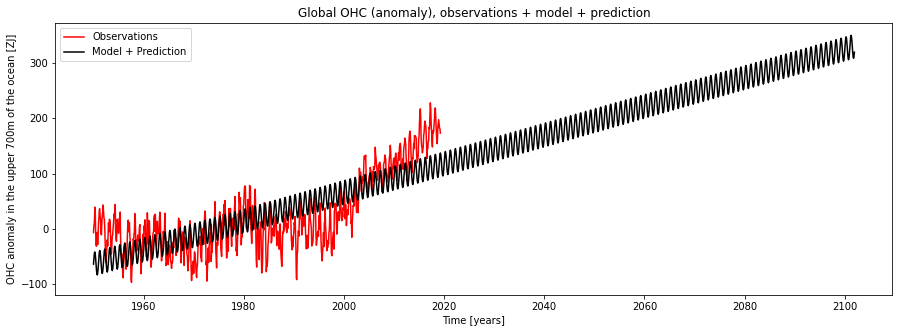

In [30]:
lr2 = LinearRegression()
RMSE_sin_700 = regressor_predict(lr2, X_sc_2019, Y_700, X_sc_2100, X_2019, X_2100, "Global OHC (anomaly), observations + model + prediction", 
                  "Time [years]", "OHC anomaly in the upper 700m of the ocean [ZJ]")

## Linear Regression with dataset separation

In [31]:
def reg_lin_2_segments(t_sep, upper=2000):
  lr_sep_1 = LinearRegression()
  lr_sep_2 = LinearRegression()

  t_tot = len(depth2000.time)
  # len(depth2000.time) = len(depth700.time)

  temps_sep_1 = np.arange(0,t_sep,1)
  temps_sep_2 = np.arange(t_sep,t_tot,1)
  temps_sep_pred = np.arange(t_sep,1824,1)

  col1_sep_1 = temps_sep_1
  col2_sep_1 = np.sin(2*np.pi*f*temps_sep_1)
  col3_sep_1 = np.cos(2*np.pi*f*temps_sep_1)

  col1_sep_2 = temps_sep_2
  col2_sep_2 = np.sin(2*np.pi*f*temps_sep_2)
  col3_sep_2 = np.cos(2*np.pi*f*temps_sep_2)

  X_sep_1 = np.vstack((col1_sep_1,col2_sep_1,col3_sep_1)).T
  X_sep_2 = np.vstack((col1_sep_2,col2_sep_2,col3_sep_2)).T

  if upper==2000:
    Y_sep_1 = OHC_2000[:t_sep]
    Y_sep_2 = OHC_2000[t_sep:]
  elif upper==700:
    Y_sep_1 = OHC_700[:t_sep]
    Y_sep_2 = OHC_700[t_sep:]
  
  col1_pred = temps_sep_pred
  col2_pred = np.sin(2*np.pi*f*temps_sep_pred)
  col3_pred = np.cos(2*np.pi*f*temps_sep_pred) 

  X_sep_pred = np.vstack((col1_pred,col2_pred,col3_pred)).T
  
  lr_sep_1.fit(X_sep_1,Y_sep_1)
  lr_sep_2.fit(X_sep_2,Y_sep_2)
  
  Yhat_sep1 = lr_sep_1.predict(X_sep_1)
  Yhat_sep2 = lr_sep_2.predict(X_sep_2)

  Yhat_sep_pred = lr_sep_2.predict(X_sep_pred)

  RMSE_sep_1 = np.sqrt(mean_squared_error(Y_sep_1,Yhat_sep1))
  RMSE_sep_2 = np.sqrt(mean_squared_error(Y_sep_2,Yhat_sep2))

  # We first tried : RMSE_tot = RMSE_sep_1 + RMSE_sep_2
  # But the results weren't convenient, we decided to add weighting :
  RMSE_tot = t_sep / t_tot * RMSE_sep_1 + (t_tot - t_sep) / t_tot * RMSE_sep_2

  return RMSE_sep_1, RMSE_sep_2, RMSE_tot, temps_sep_1, temps_sep_2, temps_sep_pred, X_sep_1, X_sep_2, Y_sep_1, Y_sep_2, X_sep_pred, Yhat_sep1, Yhat_sep2, Yhat_sep_pred

To find the best `t_sep`, we defined this loop :

In [32]:
RMSE_list = []
t_sep_list = []

for i in range(1,len(depth700.time)-1):
  RMSE_sep_1, RMSE_sep_2, RMSE_tot, temps_sep_1, temps_sep_2, temps_sep_pred, X_sep_1, X_sep_2, Y_sep_1, Y_sep_2, X_sep_pred, Yhat_sep1, Yhat_sep2, Yhat_sep_pred = reg_lin_2_segments(i,2000)
  RMSE_list.append(RMSE_tot)
  t_sep_list.append(i)

In [33]:
RMSE_arr = np.array(RMSE_list)
t_sep_arr = np.array(t_sep_list)

min_rmse = np.min(RMSE_arr)
i_min_rmse = np.argmin(RMSE_arr)
t_sep_min_rmse = t_sep_arr[i_min_rmse]

print(min_rmse)
print(i_min_rmse)
print(t_sep_min_rmse)

28.278174201628772
576
577


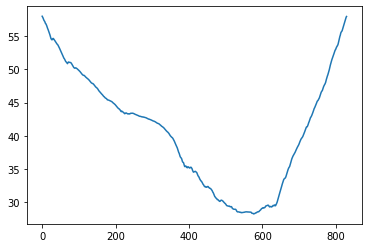

In [34]:
plt.plot(RMSE_arr)

The best `t_sep` is `t_sep_min_rmse = 577` according to the previous loop (for the data in the upper 2000m of the ocean). 

In [35]:
RMSE_sep_1, RMSE_sep_2, RMSE_tot, temps_sep_1, temps_sep_2, temps_sep_pred, X_sep_1, X_sep_2, Y_sep_1, Y_sep_2, X_sep_pred, Yhat_sep1, Yhat_sep2, Yhat_sep_pred = reg_lin_2_segments(t_sep_min_rmse,2000)


In [36]:
# Definitions of the different IPCC scenarios estimations and their confidence interval
xSSP1 = np.array((2103))
xSSP2 = np.array((2104))
xSSP3 = np.array((2105))
xSSP5 = np.array((2106))

SSP1 = np.array((1100))
SSP2 = np.array((1450))
SSP3 = np.array((1800))
SSP5 = np.array((2200))

SSP1err = np.array((550))
SSP2err = np.array((550))
SSP3err = np.array((550))
SSP5err = np.array((800))

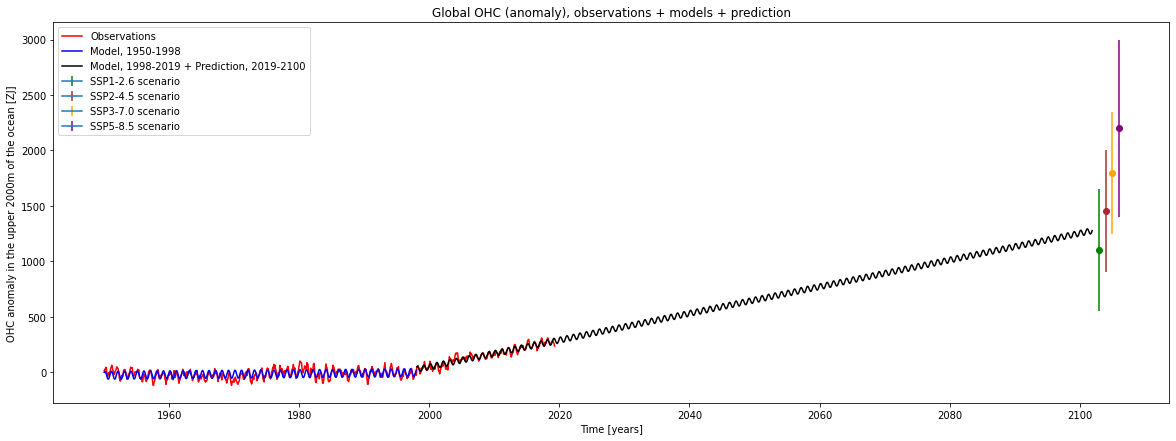

In [37]:
t_aff = np.arange(0,len(depth2000.time),1)
print('')
plt.figure(figsize=(20,7))
plt.title("Global OHC (anomaly), observations + models + prediction")
# f"2 Linear Regressions + sinusoidal seasons, t_sep = {t_sep_min_rmse-1} months after January 1950"
plt.plot(t_aff / 12 + 1950, OHC_2000, c='r', label='Observations')
plt.plot(temps_sep_1 / 12 + 1950, Yhat_sep1, 'b', label='Model, 1950-1998')
plt.plot(temps_sep_pred / 12 + 1950, Yhat_sep_pred, 'k', label='Model, 1998-2019 + Prediction, 2019-2100')
# On a divisé tous les temps par 12 (pour transformer les mois en années) puis
# on a additionné 1950 pour démarrer en 1950 (date de début des données)
plt.errorbar(xSSP1, SSP1, SSP1err, ecolor='green', label='SSP1-2.6 scenario')
plt.errorbar(xSSP2, SSP2, SSP2err, ecolor='brown', label='SSP2-4.5 scenario')
plt.errorbar(xSSP3, SSP3, SSP3err, ecolor='orange', label='SSP3-7.0 scenario')
plt.errorbar(xSSP5, SSP5, SSP5err, ecolor='purple', label='SSP5-8.5 scenario')
plt.scatter(xSSP1, SSP1, color='green')
plt.scatter(xSSP2, SSP2, color='brown')
plt.scatter(xSSP3, SSP3, color='orange')
plt.scatter(xSSP5, SSP5, color='purple')


plt.xlabel("Time [years]")
plt.ylabel("OHC anomaly in the upper 2000m of the ocean [ZJ]")
plt.legend()

We now compare the RMSE for these different linear regressions :

In [38]:
RMSE_sep = (RMSE_sep_1+RMSE_sep_2)/2
print(RMSE_lin_2000)
print(RMSE_sin_2000)
print(RMSE_sep)

62.790696987892005
60.32117981389153
26.152369925817453


It was already clear that the linear regression model with dataset separation performed better than the other two, the RMSE further proves it.

## Decision Tree Regressor - with X_sc

0.0

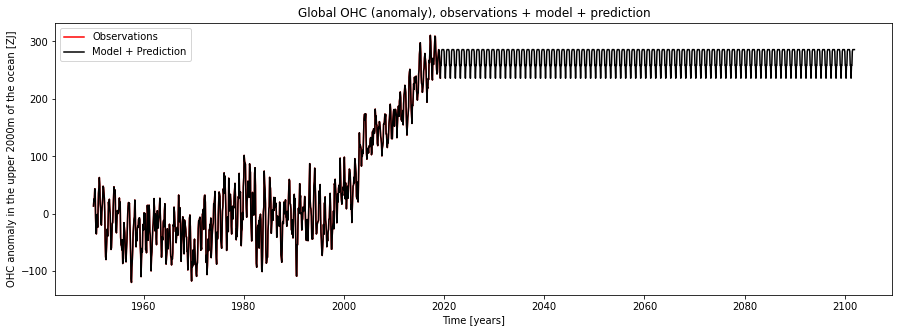

In [39]:
from sklearn.tree import DecisionTreeRegressor
rf1 = DecisionTreeRegressor()
regressor_predict(rf1, X_sc_2019, Y_2000, X_sc_2100, X_2019, X_2100, "Global OHC (anomaly), observations + model + prediction", 
                  "Time [years]", "OHC anomaly in the upper 2000m of the ocean [ZJ]")

## Decision Tree Regressor - with X

0.0

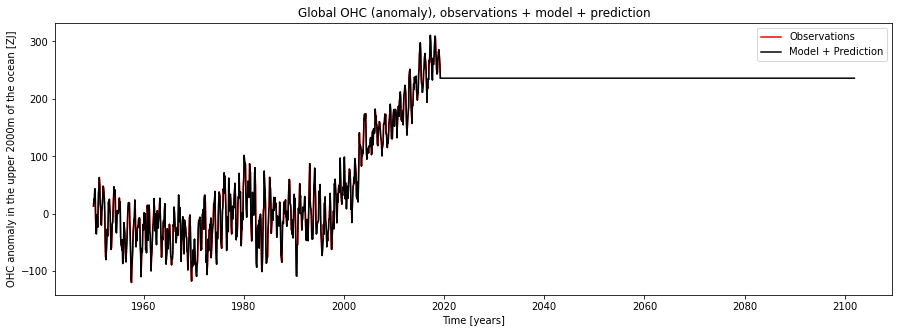

In [40]:
rf2 = DecisionTreeRegressor()
regressor_predict(rf2, X_2019, Y_2000, X_2100, X_2019, X_2100, "Global OHC (anomaly), observations + model + prediction", 
                  "Time [years]", "OHC anomaly in the upper 2000m of the ocean [ZJ]")

## Ada Boost Regressor

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


30.182340520130232

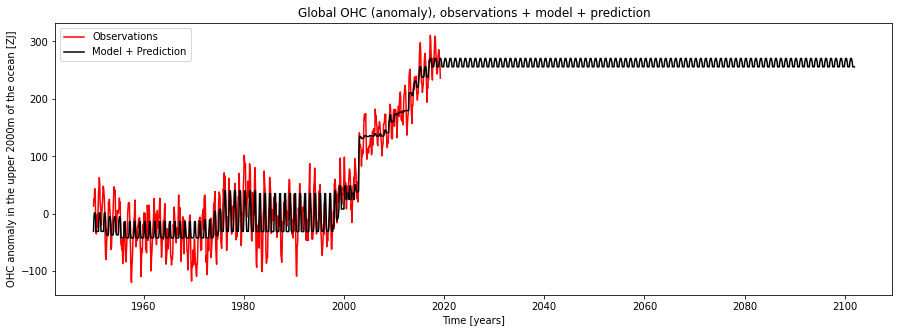

In [41]:
from sklearn.ensemble import AdaBoostRegressor
ada = AdaBoostRegressor()
regressor_predict(ada, X_sc_2019, Y_2000, X_sc_2100, X_2019, X_2100, "Global OHC (anomaly), observations + model + prediction", 
                  "Time [years]", "OHC anomaly in the upper 2000m of the ocean [ZJ]")

In [42]:
from sklearn.svm import SVR
t = np.arange(0,len(depth700.time),1)
model=SVR(C=50^30, epsilon=10^30)
model.fit(t[:,None],depth2000.sum_S_z_OHC)
y_hat=model.predict(t[:,None])

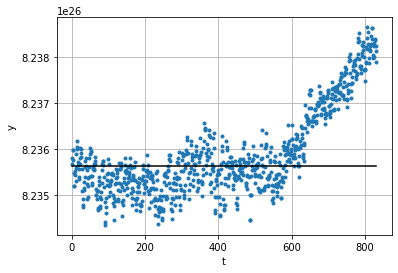

In [43]:
plt.plot(t,depth2000.sum_S_z_OHC,'.')
plt.plot(t,y_hat,'k-')
plt.xlabel('t')
plt.ylabel('y')
plt.grid()

## Time Series using RNNs : 

In [46]:
Y = depth2000['sum_S_z_OHC']/1e21
ref_OHC = depth2000['sum_S_z_OHC'].sel(time=slice("1950", "1954-12"))
ref_OHC = (ref_OHC/1e21).mean()
rescaled_Y = Y-ref_OHC

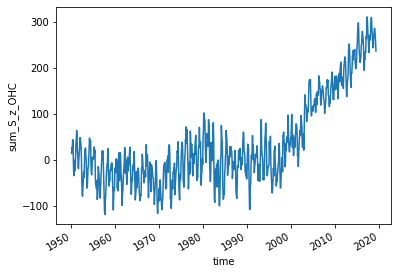

In [47]:
rescaled_Y.plot()

In [48]:
time = np.arange(0,len(depth2000.time))
series = np.array(rescaled_Y)

In [49]:
WINDOW_SIZE = 8
BATCH_SIZE = 12
SHUFFLE_BUFFER_SIZE = 32

In [50]:
import tensorflow as tf
def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE, shuffle_buffer=SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


# Apply the transformation to the training set
train_set = windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE, shuffle_buffer=SHUFFLE_BUFFER_SIZE)

In [51]:
def create_uncompiled_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(32,5,strides=1,
                      activation="relu",
                      padding='causal',input_shape =[None,1]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences = True)),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(32,activation ='relu'),
        tf.keras.layers.Dense(32,activation ='relu'),
        tf.keras.layers.Dense(1),
    ]) 
    
    return model

In [52]:
def create_model():
    model = create_uncompiled_model()
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["mae"])  

    return model

In [53]:
model = create_model()
history = model.fit(train_set, epochs=100)

69/69 [==============================] - 1s 15ms/step - loss: 6.1106 - mae: 6.5890
Epoch 98/100
69/69 [==============================] - 1s 15ms/step - loss: 6.2213 - mae: 6.7007
Epoch 99/100
69/69 [==============================] - 1s 15ms/step - loss: 6.9100 - mae: 7.3821
Epoch 100/100
69/69 [==============================] - 1s 15ms/step - loss: 6.5315 - mae: 7.0056


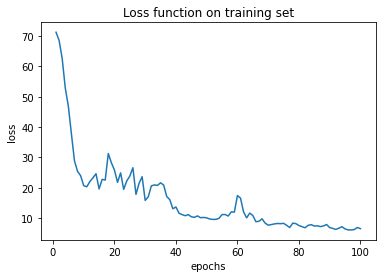

In [54]:
epochs = np.arange(1,101)
plt.plot(epochs,history.history['loss'])
plt.xlabel("epochs")
plt.ylabel('loss')
plt.title("Loss function on training set")
plt.show()

In [55]:
# Initialize a list
forecast = []

# Use the model to predict data points per window size
for time_stamp in range(len(series) - WINDOW_SIZE):
    forecast.append(model.predict(series[time_stamp:time_stamp + WINDOW_SIZE][np.newaxis]))

1/1 [==============================] - 0s 18ms/step


In [56]:
temp = np.array(forecast).squeeze()

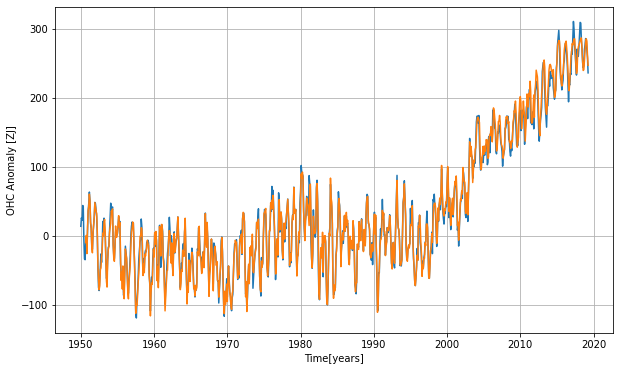

In [57]:
# Slice the forecast to get only the predictions for the validation set
import matplotlib.pyplot as plt
# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(time/ 12 + 1950, series,label = "OHC Evolution")
plt.plot(time[WINDOW_SIZE:]/ 12 + 1950, temp,label = "RNN Model")
plt.xlabel("Time[years]")
plt.ylabel("OHC Anomaly [ZJ]")
plt.grid(True)
plt.show()

In [58]:
time_till_12_2100 = 981
for time_future in range(time_till_12_2100):
      next = model.predict(temp[-28:][np.newaxis])
      next_OHC = np.array(next).squeeze()
      temp = np.append(temp, next_OHC)

1/1 [==============================] - 0s 23ms/step


In [59]:
time_full = np.arange(1,len(temp)+1)

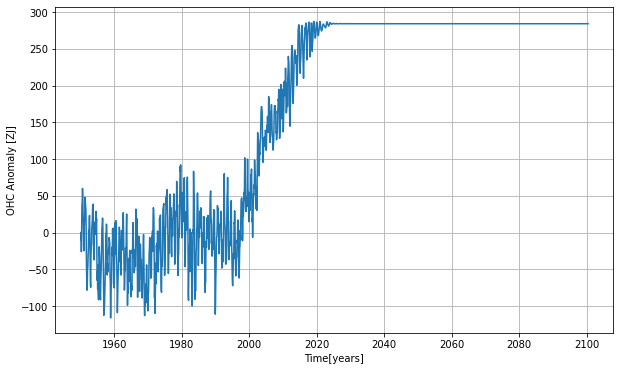

In [60]:
plt.figure(figsize=(10, 6))
plt.plot(time_full/ 12 + 1950, temp, label = "RNN Prediction")
plt.xlabel("Time[years]")
plt.ylabel("OHC Anomaly [ZJ]")
plt.grid(True)
plt.show()

## Local study

After studying the global variations of OHC, we now study it more locally. To plot acceptable data, we have to divide the calculated OHC by height and area, because the grid isn't regular (height is a function of depth, and area a function of latitude) and we can't compare the OHC between two cells of these cells don't have the same size.

In [61]:
depth2000['OHC_par_z_par_A'] = depth2000['OHC']/depth2000['dz']/depth2000['dA']
depth700['OHC_par_z_par_A'] = depth700['OHC']/depth700['dz']/depth700['dA']

We can now plot some examples :

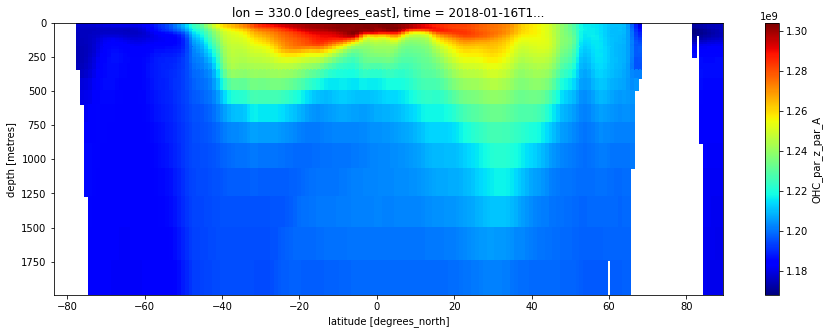

In [62]:
depth2000['OHC_par_z_par_A'].sel(time='2018', lon='330', method='nearest').plot(cmap='jet', yincrease=False, figsize=(15,5))

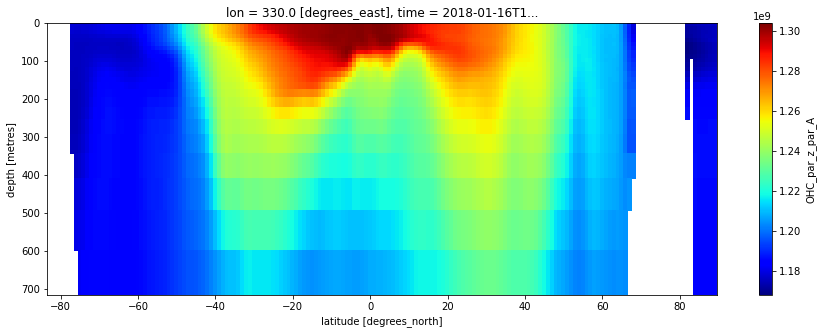

In [63]:
depth700['OHC_par_z_par_A'].sel(time='2018', lon='330', method='nearest').plot(cmap='jet', yincrease=False, figsize=(15,5))

We then try to compare the mean OHC in the upper 2000m of the ocean between the years 1950-1958 and 2010-2018 and between the years 1970-1978 and 2010-2018 ; at lon=330E=30W and lon=310E=50W.

In [64]:
OHC_lon_330_1950_58 = depth2000['OHC_par_z_par_A'].sel(time=slice('1950','1958')).sel(lon='330', method='nearest').mean('time')
OHC_lon_330_1970_78 = depth2000['OHC_par_z_par_A'].sel(time=slice('1970','1978')).sel(lon='330', method='nearest').mean('time')
OHC_lon_330_2010_18 = depth2000['OHC_par_z_par_A'].sel(time=slice('2010','2018')).sel(lon='330', method='nearest').mean('time')
OHC_lon_330_diff_2010_18_1950_58 = OHC_lon_330_2010_18 - OHC_lon_330_1950_58
OHC_lon_330_diff_2010_18_1970_78 = OHC_lon_330_2010_18 - OHC_lon_330_1970_78

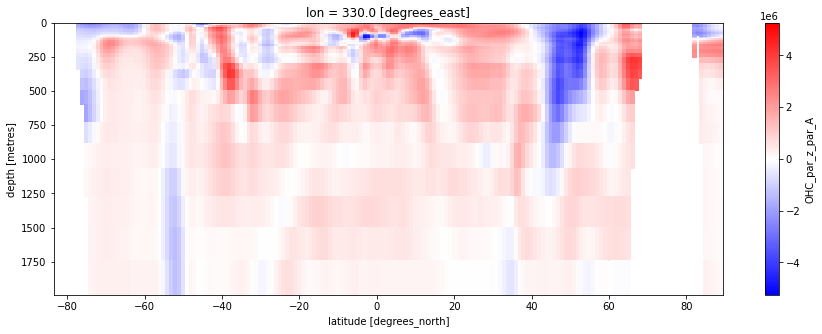

In [65]:
OHC_lon_330_diff_2010_18_1950_58.plot(cmap='bwr', yincrease=False, figsize=(15,5))

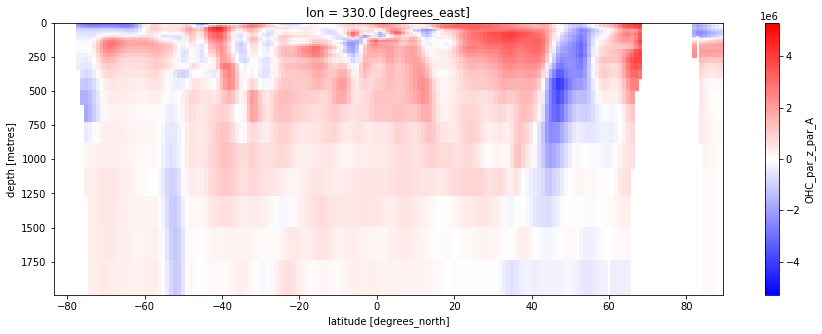

In [66]:
OHC_lon_330_diff_2010_18_1970_78.plot(cmap='bwr', yincrease=False, figsize=(15,5))

In [67]:
OHC_lon_310_1950_58 = depth2000['OHC_par_z_par_A'].sel(time=slice('1950','1958')).sel(lon='310', method='nearest').mean('time')
OHC_lon_310_1970_78 = depth2000['OHC_par_z_par_A'].sel(time=slice('1970','1978')).sel(lon='310', method='nearest').mean('time')
OHC_lon_310_2010_18 = depth2000['OHC_par_z_par_A'].sel(time=slice('2010','2018')).sel(lon='310', method='nearest').mean('time')
OHC_lon_310_diff_2010_18_1950_58 = OHC_lon_310_2010_18 - OHC_lon_310_1950_58
OHC_lon_310_diff_2010_18_1970_78 = OHC_lon_310_2010_18 - OHC_lon_310_1970_78

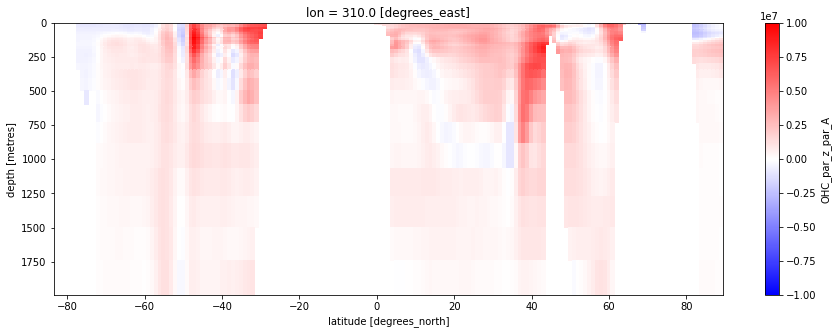

In [ ]:
OHC_lon_310_diff_2010_18_1950_58.plot(cmap='bwr', yincrease=False, figsize=(15,5))

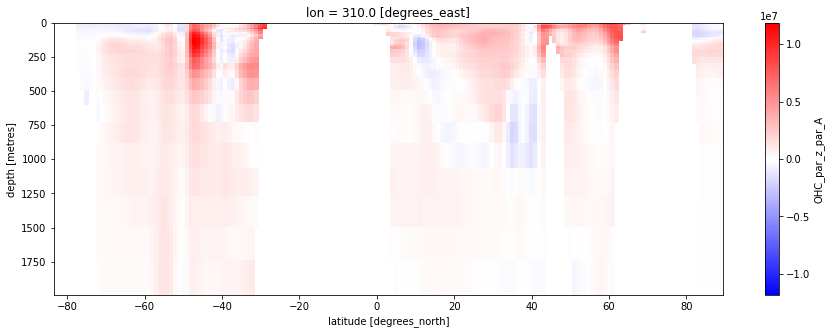

In [ ]:
OHC_lon_310_diff_2010_18_1970_78.plot(cmap='bwr', yincrease=False, figsize=(15,5))

At lon=310, the Gulf Stream is really noticeable at lat=40 approximately. We can here clearly see that the OHC has increased alongside the Gulf Stream, between the years 1950-58 and 2010-18.

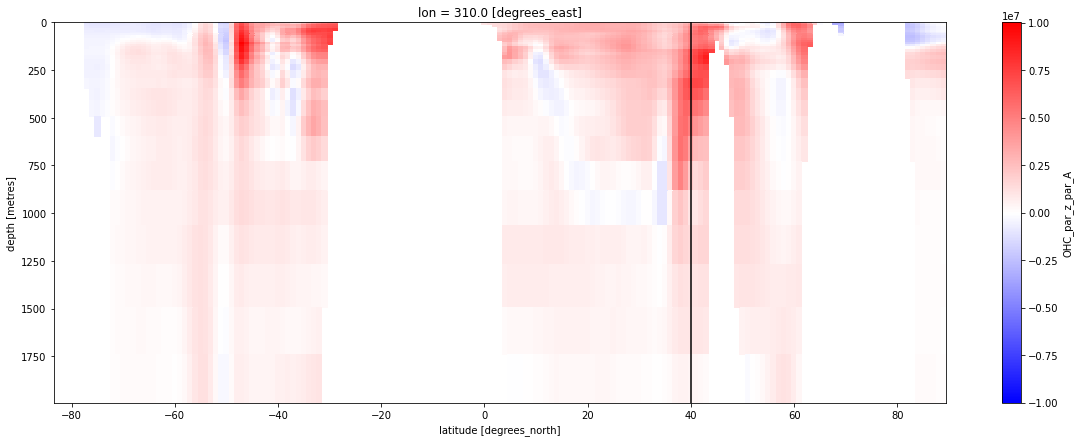

In [ ]:
fig,ax1 = plt.subplots(ncols=1, figsize=(20,7))
OHC_lon_310_diff_2010_18_1950_58.plot(ax=ax1, cmap='bwr', yincrease=False)
ax1.vlines(40,0,2000)